# Model evaluation

## General Data Wrangling

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, FunctionTransformer, PowerTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
import altair as alt
alt.renderers.enable('mimetype')
alt.data_transformers.enable('data_server')

DataTransformerRegistry.enable('data_server')

In [2]:
import sys
sys.path.append('code/')
from functions import *

In [3]:
data_full = pd.read_csv( '../01-data/data_merged_20220910_norm.csv')
data_full = data_full.query('H_Age<100&Draw>0').reset_index( drop = True)
y = data_full[ 'Winner']

C:\Users\User\AppData\Local\Temp\ipykernel_1380\2406342619.py:1: DtypeWarning: Columns (62) have mixed types. Specify dtype option on import or set low_memory=False.
  data_full = pd.read_csv( '../01-data/data_merged_20220910_norm.csv')


In [4]:
X = data_full.loc[ :, data_full.columns.str.startswith( 'ActualWeight') | data_full.columns.str.startswith( 'DeclaredHorseWeight') | \
    data_full.columns.str.startswith( 'WinOdds') | data_full.columns.str.startswith( 'Draw') | \
    data_full.columns.str.startswith( 'J_Total_') | data_full.columns.str.startswith( 'J_TotalStakes_') | \
    data_full.columns.str.startswith( 'J_Rate_') | \
    data_full.columns.str.startswith( 'T_Total_') | data_full.columns.str.startswith( 'T_TotalStakes_') | \
    data_full.columns.str.startswith( 'T_Rate') | \
    data_full.columns.str.startswith( 'H_Rate_') | data_full.columns.str.startswith( 'H_Total') | \
    data_full.columns.str.startswith( 'H_TotalStake') | data_full.columns.str.startswith( 'CombinedRating') | \
    data_full.columns.str.startswith( 'H_Age') | data_full.columns.str.startswith( 'WeightDiff') | \
    data_full.columns.str.startswith( 'LastRace_nDays') | data_full.columns.str.startswith( 'PreviousPlace') | \
    data_full.columns.str.startswith( 'AvgPlace3') | data_full.columns.str.startswith( 'AvgPlace5') | \
    data_full.columns.str.startswith( 'Place')] # Place is added for downsampling

print( X.columns)

Index(['Place', 'ActualWeight', 'DeclaredHorseWeight', 'Draw', 'WinOdds',
       'J_Rate_win', 'J_Rate_place', 'J_Rate_show', 'T_Rate_win',
       'T_Rate_place', 'T_Rate_show', 'H_TotalStake', 'H_Total', 'H_Rate_win',
       'H_Rate_place', 'H_Rate_show', 'H_Age', 'LastRace_nDays',
       'PreviousPlace', 'AvgPlace3', 'AvgPlace5', 'WeightDiff',
       'CombinedRating', 'Place_norm', 'ActualWeight_norm',
       'DeclaredHorseWeight_norm', 'Draw_norm', 'WinOdds_norm',
       'J_Rate_win_norm', 'J_Rate_place_norm', 'J_Rate_show_norm',
       'T_Rate_win_norm', 'T_Rate_place_norm', 'T_Rate_show_norm',
       'H_TotalStake_norm', 'H_Total_norm', 'H_Rate_win_norm',
       'H_Rate_place_norm', 'H_Rate_show_norm', 'H_Age_norm',
       'LastRace_nDays_norm', 'PreviousPlace_norm', 'AvgPlace3_norm',
       'AvgPlace5_norm', 'WeightDiff_norm', 'CombinedRating_norm'],
      dtype='object')


In [5]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.2, stratify = y, random_state = 918)

Variables and corresponding transformations. (All relative indexes will not be transformed as they are theoretically normal)


| Variable | Log? | Scaling |
|----------|------|---------|
| ActualWeight | No | Standard |
| DeclaredHorseWeight | No | Standard |
| Draw | No | Standard (_Ordinal_+Scaling) |
| WinOdds | Yes  |Standard |
| J_Rate_* | No | None |
| T_Rate_* | No | None |
| H_TotalStake | Yes | Standard |
| H_Total | Yes | Standard |
| H_Rate_* | No | None |
| H_Age | No | Standard |
| LastRace_nDays | Yes | Standard |
| PreviousPlace | No | Standard |
| AvgPlace* | No | Standard |
| WeightDiff | No | Standard |
| Rating | No | Standard |


In [6]:
cols_std = [
    'ActualWeight', 'DeclaredHorseWeight', 'Draw', 'H_Age', 'PreviousPlace', 'AvgPlace3', 'AvgPlace5', 'WeightDiff', 'CombinedRating']

cols_log_std = [
    'WinOdds', 'H_TotalStake', 'H_Total', 'LastRace_nDays']

cols_passthrough = [
    'J_Rate_win', 'J_Rate_place', 'J_Rate_show', 'T_Rate_win', 'T_Rate_place', 'T_Rate_show',
    'H_Rate_win', 'H_Rate_place', 'H_Rate_show',
    'ActualWeight_norm', 'DeclaredHorseWeight_norm', 'WinOdds_norm',
    'J_Rate_win_norm', 'J_Rate_place_norm', 'J_Rate_show_norm', 'T_Rate_win_norm', 'T_Rate_place_norm', 'T_Rate_show_norm',
    'H_TotalStake_norm', 'H_Total_norm', 'H_Rate_win_norm', 'H_Rate_place_norm', 'H_Rate_show_norm', 'H_Age_norm',
    'LastRace_nDays_norm', 'PreviousPlace_norm', 'AvgPlace3_norm', 'AvgPlace5_norm', 'WeightDiff_norm', 'CombinedRating_norm']

cols_drop = [
    'Place', 'Place_norm', 'Draw_norm']

In [7]:
def log_func(x):
    return np.log(x+1)

In [8]:
log_transformer = FunctionTransformer( log_func)

In [9]:
pipe_log_std = make_pipeline(
    log_transformer, StandardScaler()
)

In [10]:
column_transformer = make_column_transformer(
    ( StandardScaler(), cols_std),
    ( pipe_log_std, cols_log_std),
    ( 'passthrough', cols_passthrough),
    ( 'drop', cols_drop)
)

## General parameters

In [11]:
scoring_metrics = [ 'precision', 'recall', 'f1']

## KNN

### Model training

In [12]:
pipe_knn = make_pipeline( column_transformer, KNeighborsClassifier())

In [13]:
cv_result_knn = cross_validate( pipe_knn, X_train, y_train, cv = 5, return_train_score = True, scoring = scoring_metrics)

In [14]:
pd.DataFrame( cv_result_knn).mean()

fit_time           0.022606
score_time         0.321994
test_precision     0.419772
train_precision    0.745790
test_recall        0.099629
train_recall       0.202489
test_f1            0.160819
train_f1           0.318459
dtype: float64

### Hyperparameter optimization

In [15]:
param_grid = {
    "kneighborsclassifier__n_neighbors": list( range( 5, 35, 5))
}

grid_search_knn = GridSearchCV(
    pipe_knn, param_grid, cv = 5, scoring = 'precision', n_jobs=-1, return_train_score = True
)

In [16]:
grid_search_knn.fit( X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['ActualWeight',
                                                                          'DeclaredHorseWeight',
                                                                          'Draw',
                                                                          'H_Age',
                                                                          'PreviousPlace',
                                                                          'AvgPlace3',
                                                                          'AvgPlace5',
                                                                          'WeightDiff',
                                                                          'CombinedRating']),
                                                                        ('pipeline',
                                                                         Pipeline(steps=[('functiontransformer',
                                                                                          FunctionTransformer(func=<function log_func...
                                                                          'H_Age_norm',
                                                                          'LastRace_nDays_norm',
                                                                          'PreviousPlace_norm',
                                                                          'AvgPlace3_norm',
                                                                          'AvgPlace5_norm',
                                                                          'WeightDiff_norm',
                                                                          'CombinedRating_norm']),
                                                                        ('drop',
                                                                         'drop',
                                                                         ['Place',
                                                                          'Place_norm',
                                                                          'Draw_norm'])])),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'kneighborsclassifier__n_neighbors': [5, 10, 15, 20,
                                                               25, 30]},
             return_train_score=True, scoring='precision')

In [17]:
cv_results_knn_opt = pd.DataFrame( grid_search_knn.cv_results_)
cv_results_knn_opt[ ['params', 'mean_test_score']].sort_values( 'mean_test_score', ascending = False)

,params,mean_test_score
4,{'kneighborsclassifier__n_neighbors': 25},0.688312
3,{'kneighborsclassifier__n_neighbors': 20},0.684149
5,{'kneighborsclassifier__n_neighbors': 30},0.683867
1,{'kneighborsclassifier__n_neighbors': 10},0.613493
2,{'kneighborsclassifier__n_neighbors': 15},0.578095
0,{'kneighborsclassifier__n_neighbors': 5},0.419772


### Final model evaluation

In [18]:
grid_search_knn.best_params_

{'kneighborsclassifier__n_neighbors': 25}

In [19]:
pipe_knn_opt = make_pipeline( column_transformer,
                              KNeighborsClassifier( n_neighbors = grid_search_knn.best_params_[ 'kneighborsclassifier__n_neighbors']))

In [20]:
pipe_knn_opt.fit( X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['ActualWeight',
                                                   'DeclaredHorseWeight',
                                                   'Draw', 'H_Age',
                                                   'PreviousPlace', 'AvgPlace3',
                                                   'AvgPlace5', 'WeightDiff',
                                                   'CombinedRating']),
                                                 ('pipeline',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(func=<function log_func at 0x0000023684AFC040>)),
                                                                  ('st...
                                                   'T_Rate_show_norm',
                                                   'H_TotalStake_norm',
                                                   'H_Total_norm',
                                                   'H_Rate_win_norm',
                                                   'H_Rate_place_norm',
                                                   'H_Rate_show_norm',
                                                   'H_Age_norm',
                                                   'LastRace_nDays_norm',
                                                   'PreviousPlace_norm',
                                                   'AvgPlace3_norm',
                                                   'AvgPlace5_norm',
                                                   'WeightDiff_norm',
                                                   'CombinedRating_norm']),
                                                 ('drop', 'drop',
                                                  ['Place', 'Place_norm',
                                                   'Draw_norm'])])),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=25))])

In [21]:
y_hat_knn_opt = pipe_knn_opt.predict( X_test)

In [22]:
better_confusion_matrix( y_test, y_hat_knn_opt, labels = [ True, False])

Predicted      
                  True False
Actual True         12   259
       False         8  3000

In [23]:
print( classification_report( y_test, y_hat_knn_opt))

              precision    recall  f1-score   support

       False       0.92      1.00      0.96      3008
        True       0.60      0.04      0.08       271

    accuracy                           0.92      3279
   macro avg       0.76      0.52      0.52      3279
weighted avg       0.89      0.92      0.89      3279



## SVC

### Model training

In [24]:
pipe_svc = make_pipeline( column_transformer, SVC())

In [25]:
cv_result_svc = cross_validate( pipe_svc, X_train, y_train, cv = 5, return_train_score = True, scoring = scoring_metrics)
pd.DataFrame( cv_result_svc)

,fit_time,score_time,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1
0,13.495735,3.851254,0.947368,0.904255,0.082949,0.098039,0.152542,0.176899
1,10.937524,2.669002,0.777778,0.920792,0.064516,0.107266,0.119149,0.192149
2,6.260998,3.207920,0.714286,0.933333,0.069124,0.113033,0.126050,0.201646
3,2.975993,1.021040,0.789474,0.910891,0.069124,0.106113,0.127119,0.190083
4,2.896946,1.179000,0.647059,0.958763,0.050926,0.107143,0.094421,0.192746


In [26]:
pd.DataFrame( cv_result_svc).mean()

fit_time           7.313439
score_time         2.385643
test_precision     0.775193
train_precision    0.925607
test_recall        0.067328
train_recall       0.106319
test_f1            0.123856
train_f1           0.190705
dtype: float64

### Hyperparameter optimization

In [27]:
param_dist = {
    'svc__C': [ 10**x for x in range( -2, 5)],
    'svc__gamma': [ 10**x for x in range( -2, 5)]
}

random_search_svc = RandomizedSearchCV(
    pipe_svc, param_dist, n_iter = 10, cv = 5, scoring = 'precision', n_jobs=-1, return_train_score = True, random_state = 918
)

In [28]:
random_search_svc.fit( X_train, y_train)
cv_results_svc_opt = pd.DataFrame( random_search_svc.cv_results_)
cv_results_svc_opt[ ['params', 'mean_test_score']].sort_values( 'mean_test_score', ascending = False).head()

,params,mean_test_score
9,"{'svc__gamma': 0.1, 'svc__C': 100}",0.380624
2,"{'svc__gamma': 0.01, 'svc__C': 10000}",0.258896
0,"{'svc__gamma': 0.01, 'svc__C': 1}",0.000000
1,"{'svc__gamma': 0.01, 'svc__C': 0.1}",0.000000
3,"{'svc__gamma': 1, 'svc__C': 1}",0.000000


In [29]:
random_search_svc.best_params_

{'svc__gamma': 0.1, 'svc__C': 100}

### Threshold tuning

In [30]:
X_cv_train, X_cv_test, y_cv_train, y_cv_test = train_test_split( X_train, y_train, test_size = 0.2, stratify = y_train, random_state = 918)

In [31]:
pipe_svc_opt = make_pipeline( column_transformer,
                              SVC( gamma = random_search_svc.best_params_[ 'svc__gamma'],
                                   C = random_search_svc.best_params_[ 'svc__C']))

Best params are {'svc__gamma': 0.1, 'svc__C': 1}. No need to re-fit every time.

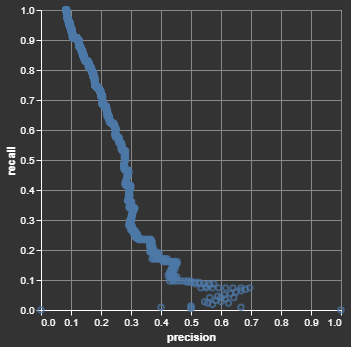

In [32]:
pr_curve( pipe_svc_opt, X_cv_train, X_cv_test, y_cv_train, y_cv_test)

A threshold of 0.40 is selected.

### Final model evaluation

In [33]:
def svc_by_proba( pipe_svc, X_test, threshold):
    proba = pipe_svc.decision_function( X_test)
    y_hat = proba > threshold
    return y_hat

In [37]:
pipe_svc_opt.fit( X_train, y_train)
y_hat_svc_opt = svc_by_proba( pipe_svc_opt, X_test, 0.40)
better_confusion_matrix( y_test, y_hat_svc_opt, labels = [ True, False])

Predicted      
                  True False
Actual True         21   250
       False        24  2984

In [38]:
print( classification_report( y_test, y_hat_svc_opt))

              precision    recall  f1-score   support

       False       0.92      0.99      0.96      3008
        True       0.47      0.08      0.13       271

    accuracy                           0.92      3279
   macro avg       0.69      0.53      0.54      3279
weighted avg       0.89      0.92      0.89      3279



## Random Forest Classifier

### Model training

In [39]:
pipe_rfc = make_pipeline( column_transformer, RandomForestClassifier())
cv_result_rfc = cross_validate( pipe_rfc, X_train, y_train, cv = 5, return_train_score = True, scoring = scoring_metrics)
pd.DataFrame( cv_result_rfc)

,fit_time,score_time,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1
0,3.088912,0.048393,0.658537,1.0,0.124424,1.000000,0.209302,1.000000
1,3.079470,0.060034,0.606061,1.0,0.092166,0.998847,0.160000,0.999423
2,5.307504,0.093757,0.588235,1.0,0.092166,1.000000,0.159363,1.000000
3,3.400319,0.050514,0.806452,1.0,0.115207,0.998847,0.201613,0.999423
4,3.154398,0.046876,0.700000,1.0,0.097222,1.000000,0.170732,1.000000


In [40]:
pd.DataFrame( cv_result_rfc).mean()

fit_time           3.606121
score_time         0.059915
test_precision     0.671857
train_precision    1.000000
test_recall        0.104237
train_recall       0.999539
test_f1            0.180202
train_f1           0.999769
dtype: float64

### Hyperparameter optimization

In [41]:
param_dist = {
    'randomforestclassifier__n_estimators': [ 100*x for x in range( 1, 11)],
    'randomforestclassifier__max_depth': [ 10*x for x in range( 1, 11)],
    'randomforestclassifier__max_features': [ 'sqrt', 'log2'],
    'randomforestclassifier__criterion': [ 'gini', 'entropy', 'log_loss'],
    'randomforestclassifier__bootstrap': [ True, False]
}

random_search_rfc = RandomizedSearchCV(
    pipe_rfc, param_dist, n_iter = 30, cv = 5, scoring = 'precision', n_jobs=-1, return_train_score = True, random_state = 918
)

random_search_rfc.fit( X_train, y_train)
cv_results_rfc_opt = pd.DataFrame( random_search_rfc.cv_results_)
cv_results_rfc_opt[ ['params', 'mean_test_score']].sort_values( 'mean_test_score', ascending = False).head()

,params,mean_test_score
16,"{'randomforestclassifier__n_estimators': 200, ...",0.733814
0,"{'randomforestclassifier__n_estimators': 700, ...",0.699647
9,"{'randomforestclassifier__n_estimators': 700, ...",0.697792
11,"{'randomforestclassifier__n_estimators': 600, ...",0.692786
1,"{'randomforestclassifier__n_estimators': 800, ...",0.691973


In [42]:
random_search_rfc.best_params_

{'randomforestclassifier__n_estimators': 200,
 'randomforestclassifier__max_features': 'log2',
 'randomforestclassifier__max_depth': 10,
 'randomforestclassifier__criterion': 'entropy',
 'randomforestclassifier__bootstrap': True}

### Threshold tuning

In [43]:
pipe_rfc_opt = make_pipeline( column_transformer,
                              RandomForestClassifier( n_estimators = random_search_rfc.best_params_[ 'randomforestclassifier__n_estimators'],
                                                      max_features = random_search_rfc.best_params_[ 'randomforestclassifier__max_features'],
                                                      max_depth = random_search_rfc.best_params_[ 'randomforestclassifier__max_depth'],
                                                      criterion = random_search_rfc.best_params_[ 'randomforestclassifier__criterion'],
                                                      bootstrap = random_search_rfc.best_params_[ 'randomforestclassifier__bootstrap']))

Best params are {'randomforestclassifier__n_estimators': 300,
 'randomforestclassifier__max_features': 'log2',
 'randomforestclassifier__max_depth': 90,
 'randomforestclassifier__criterion': 'log_loss',
 'randomforestclassifier__bootstrap': True}. No need to re-fit every time.

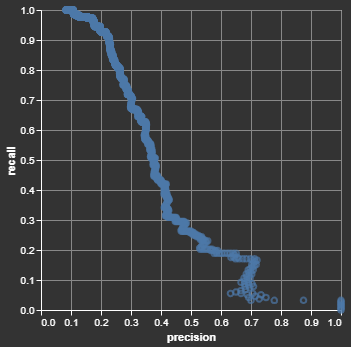

In [44]:
pr_curve( pipe_rfc_opt, X_cv_train, X_cv_test, y_cv_train, y_cv_test)

A threshold of 0.41 is selected.

### Final model evaluation

In [45]:
def rfc_by_proba( pipe_rfc, X_test, threshold):
    proba = pipe_rfc.predict_proba( X_test)[ :, 1]
    y_hat = proba > threshold
    return y_hat

In [46]:
pipe_rfc_opt.fit( X_train, y_train)
y_hat_rfc_opt = rfc_by_proba( pipe_rfc_opt, X_test, 0.58)
better_confusion_matrix( y_test, y_hat_rfc_opt, labels = [ True, False])

Predicted      
                  True False
Actual True         14   257
       False         6  3002

In [47]:
print( classification_report( y_test, y_hat_rfc_opt))

              precision    recall  f1-score   support

       False       0.92      1.00      0.96      3008
        True       0.70      0.05      0.10       271

    accuracy                           0.92      3279
   macro avg       0.81      0.52      0.53      3279
weighted avg       0.90      0.92      0.89      3279



## Gaussian Naive Bayes

### Model training

In [48]:
pipe_nb = make_pipeline( column_transformer, PowerTransformer(), GaussianNB())
cv_result_nb = cross_validate( pipe_nb, X_train, y_train, cv = 5, return_train_score = True, scoring = scoring_metrics)
pd.DataFrame( cv_result_nb)

,fit_time,score_time,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1
0,0.543751,0.029922,0.204225,0.207994,0.668203,0.678201,0.312837,0.318354
1,0.587637,0.015031,0.186370,0.211504,0.617512,0.682814,0.286325,0.322968
2,0.585286,0.015629,0.195225,0.209993,0.640553,0.668973,0.299247,0.319647
3,0.568062,0.022657,0.224784,0.202351,0.718894,0.655133,0.342481,0.309200
4,0.537249,0.005034,0.221557,0.203795,0.685185,0.668203,0.334842,0.312332


In [49]:
pd.DataFrame( cv_result_svc).mean()

fit_time           7.313439
score_time         2.385643
test_precision     0.775193
train_precision    0.925607
test_recall        0.067328
train_recall       0.106319
test_f1            0.123856
train_f1           0.190705
dtype: float64

### Threshold tuning

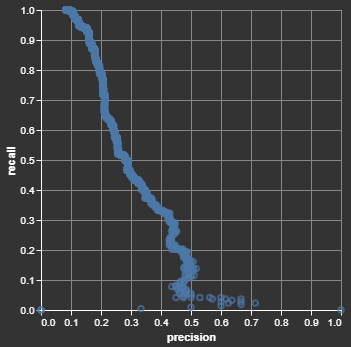

In [50]:
pr_curve( pipe_nb, X_cv_train, X_cv_test, y_cv_train, y_cv_test)

A threshold of 0.999999 is selected.

### Final model evaluation

In [51]:
def nb_by_proba( pipe_nb, X_test, threshold):
    proba = pipe_nb.predict_proba( X_test)[ :, 1]
    y_hat = proba > threshold
    return y_hat
pipe_nb.fit( X_train, y_train)
y_hat_nb = nb_by_proba( pipe_nb, X_test, 0.999999)
better_confusion_matrix( y_test, y_hat_nb, labels = [ True, False])

Predicted      
                  True False
Actual True         57   214
       False        80  2928

In [52]:
print( classification_report( y_test, y_hat_nb))

              precision    recall  f1-score   support

       False       0.93      0.97      0.95      3008
        True       0.42      0.21      0.28       271

    accuracy                           0.91      3279
   macro avg       0.67      0.59      0.62      3279
weighted avg       0.89      0.91      0.90      3279



## Logistic Regression

### Model training

In [53]:
pipe_logreg = make_pipeline( column_transformer, LogisticRegression( max_iter = 500, solver = 'saga'))
cv_result_logreg = cross_validate( pipe_logreg, X_train, y_train, cv = 5, return_train_score = True, scoring = scoring_metrics)
pd.DataFrame( cv_result_logreg)

,fit_time,score_time,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1
0,1.289361,0.062473,0.615385,0.616236,0.221198,0.192618,0.325424,0.293497
1,1.750174,0.015632,0.558824,0.618705,0.175115,0.198385,0.266667,0.300437
2,1.609119,0.000000,0.554054,0.624549,0.188940,0.199539,0.281787,0.302448
3,1.547853,0.015626,0.672131,0.617188,0.188940,0.182238,0.294964,0.281389
4,1.545745,0.015581,0.592593,0.623616,0.148148,0.194700,0.237037,0.296752


In [54]:
pd.DataFrame( cv_result_logreg).mean()

fit_time           1.548450
score_time         0.021862
test_precision     0.598597
train_precision    0.620059
test_recall        0.184468
train_recall       0.193496
test_f1            0.281176
train_f1           0.294904
dtype: float64

### Hyperparameter optimization

In [56]:
param_dist = {
    'logisticregression__C': [ 10**x for x in range( -2, 5)],
    'logisticregression__penalty': [ 'none', 'l2', 'l1', 'elasticnet'],
    'logisticregression__l1_ratio': [ 0, 0.5, 1]
}

grid_search_logreg = RandomizedSearchCV(
    pipe_logreg, param_dist, cv = 20, scoring = 'precision', n_jobs=-1, return_train_score = True, random_state = 918
)

grid_search_logreg.fit( X_train, y_train)
cv_results_logreg_opt = pd.DataFrame( grid_search_logreg.cv_results_)
cv_results_logreg_opt[ ['params', 'mean_test_score']].sort_values( 'mean_test_score', ascending = False).head()

C:\Users\User\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


,params,mean_test_score
3,"{'logisticregression__penalty': 'l2', 'logisti...",0.647035
0,"{'logisticregression__penalty': 'none', 'logis...",0.603293
1,"{'logisticregression__penalty': 'elasticnet', ...",0.603293
2,"{'logisticregression__penalty': 'none', 'logis...",0.603293
4,"{'logisticregression__penalty': 'l2', 'logisti...",0.603293


In [57]:
grid_search_logreg.best_params_

{'logisticregression__penalty': 'l2',
 'logisticregression__l1_ratio': 0,
 'logisticregression__C': 0.01}

### Threshold tuning

In [58]:
pipe_logreg_opt = make_pipeline( column_transformer,
                                 LogisticRegression( max_iter = 500,
                                                     solver = 'saga',
                                                     C = grid_search_logreg.best_params_[ 'logisticregression__C'],
                                                     penalty = grid_search_logreg.best_params_[ 'logisticregression__penalty'],
                                                     l1_ratio = grid_search_logreg.best_params_[ 'logisticregression__l1_ratio']))

C:\Users\User\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


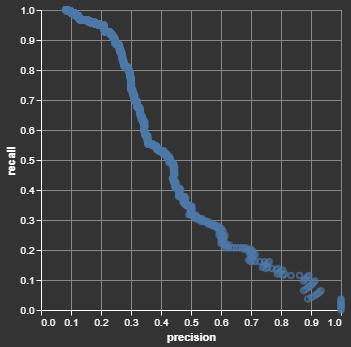

In [59]:
pr_curve( pipe_logreg_opt, X_cv_train, X_cv_test, y_cv_train, y_cv_test)

A threshold of 0.45 is selected.

### Final model evaluation

In [60]:
def logreg_by_proba( pipe_logreg, X_test, threshold):
    proba = pipe_logreg.predict_proba( X_test)[ :, 1]
    y_hat = proba > threshold
    return y_hat
pipe_logreg_opt.fit( X_train, y_train)
y_hat_logreg_opt = logreg_by_proba( pipe_logreg_opt, X_test, 0.38)
better_confusion_matrix( y_test, y_hat_logreg_opt, labels = [ True, False])

C:\Users\User\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


Predicted      
                  True False
Actual True         71   200
       False        51  2957

In [61]:
print( classification_report( y_test, y_hat_logreg_opt))

              precision    recall  f1-score   support

       False       0.94      0.98      0.96      3008
        True       0.58      0.26      0.36       271

    accuracy                           0.92      3279
   macro avg       0.76      0.62      0.66      3279
weighted avg       0.91      0.92      0.91      3279



## Linear SVC

### Model training

In [62]:
pipe_lsvc = make_pipeline( column_transformer, LinearSVC( dual = False, random_state = 918))
cv_result_lsvc = cross_validate( pipe_lsvc, X_train, y_train, cv = 5, return_train_score = True, scoring = scoring_metrics)
pd.DataFrame( cv_result_lsvc)

,fit_time,score_time,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1
0,0.235033,0.008964,0.710526,0.699248,0.124424,0.107266,0.211765,0.186000
1,0.243047,0.008953,0.666667,0.729927,0.110599,0.115340,0.189723,0.199203
2,0.223024,0.012010,0.718750,0.726027,0.105991,0.122261,0.184739,0.209279
3,0.288048,0.008955,0.771429,0.710938,0.124424,0.104960,0.214286,0.182915
4,0.210100,0.000000,0.800000,0.721805,0.092593,0.110599,0.165975,0.191808


In [63]:
pd.DataFrame( cv_result_lsvc).mean()

fit_time           0.239850
score_time         0.007776
test_precision     0.733474
train_precision    0.717589
test_recall        0.111606
train_recall       0.112085
test_f1            0.193298
train_f1           0.193841
dtype: float64

### Hyperparameter optimization

In [64]:
param_dist = {
    'linearsvc__C': [ 10**x for x in range( -2, 5)]
}

grid_search_lsvc = GridSearchCV(
    pipe_lsvc, param_dist, cv = 5, scoring = 'precision', n_jobs=-1, return_train_score = True
)

grid_search_lsvc.fit( X_train, y_train)
cv_results_lsvc_opt = pd.DataFrame( grid_search_lsvc.cv_results_)
cv_results_lsvc_opt[ ['params', 'mean_test_score']].sort_values( 'mean_test_score', ascending = False).head()

,params,mean_test_score
2,{'linearsvc__C': 1},0.733474
3,{'linearsvc__C': 10},0.723677
1,{'linearsvc__C': 0.1},0.719809
4,{'linearsvc__C': 100},0.717300
5,{'linearsvc__C': 1000},0.717300


In [65]:
grid_search_lsvc.best_params_

{'linearsvc__C': 1}

### Threshold tuning

In [66]:
pipe_lsvc_opt = make_pipeline( column_transformer,
                               LinearSVC( dual = False,
                                          C = grid_search_lsvc.best_params_[ 'linearsvc__C'],
                                          random_state = 918))

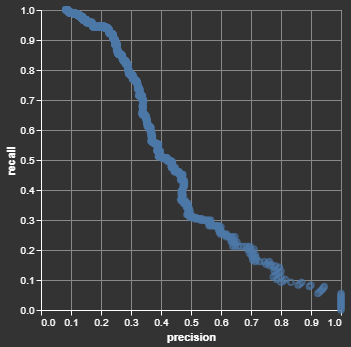

In [67]:
pr_curve( pipe_lsvc_opt, X_cv_train, X_cv_test, y_cv_train, y_cv_test)

A threshold of -0.16 is selected.

### Final model evaluation

In [68]:
def lsvc_by_proba( pipe_lsvc, X_test, threshold):
    proba = pipe_lsvc.decision_function( X_test)
    y_hat = proba > threshold
    return y_hat
pipe_lsvc_opt.fit( X_train, y_train)
y_hat_lsvc_opt = lsvc_by_proba( pipe_lsvc_opt, X_test, -0.0113)
better_confusion_matrix( y_test, y_hat_lsvc_opt, labels = [ True, False])

Predicted      
                  True False
Actual True         31   240
       False        15  2993

In [69]:
print( classification_report( y_test, y_hat_lsvc_opt))

              precision    recall  f1-score   support

       False       0.93      1.00      0.96      3008
        True       0.67      0.11      0.20       271

    accuracy                           0.92      3279
   macro avg       0.80      0.55      0.58      3279
weighted avg       0.90      0.92      0.90      3279

